<a href="https://colab.research.google.com/github/enriqueasegura/Quantum-X/blob/master/QC_Task_VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
!pip install git+https://github.com/quantumlib/Cirq
  
import matplotlib.pyplot as plt
from pandas import DataFrame
import cirq
from cirq.ops import CNOT, TOFFOLI
from cirq import Simulator
import random
from sympy import Symbol
from cirq.circuits import InsertStrategy

"""
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

import matplotlib

!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf
"""

  Cloning https://github.com/quantumlib/Cirq to /tmp/pip-req-build-399t7yvv
  Running command git clone -q https://github.com/quantumlib/Cirq /tmp/pip-req-build-399t7yvv
  Created wheel for cirq: filename=cirq-0.8.0.dev0-cp36-none-any.whl size=1295555 sha256=64ed395d2c74337773ff1d6dd303fffa22ae709e2ce70da8ccab706988dadf05
  Stored in directory: /tmp/pip-ephem-wheel-cache-kq1vbl26/wheels/c9/f4/ee/029123a49c5e2d75d08c2a9f937e207b88f045901db04632a7
Successfully built cirq


'\n! sudo apt-get install texlive-latex-recommended #1\n! sudo apt-get install dvipng texlive-fonts-recommended #2\n! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3\n! unzip type1cm.zip -d /tmp/type1cm #4\n! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5\n! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6\n! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7\n! sudo texhash #8\n\nimport matplotlib\n\n!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf\n'

Task 4

10 Feb update: I changed the matrix slightly - added the minus sign compared to the original one. This should make the solution less degenerate.

Find the lowest eigenvalue of the following matrix:

$\begin{equation*}
H = 
\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & -1 & 1& 0 \\
0 & 1 & -1& 0 \\\
0 & 0 & 0 & 0 
\end{pmatrix}
\end{equation*}
$

using VQE-like circuits, handwritten by yourself.

In general this exercise might be pretty difficult, so below there are a couple of tips. I’ve written them in pale font, so that those of you who embrace the challenge don’t look at them accidentally ;) 
1. It requires decomposing the matrix to sum of Pauli terms. 
2. Decomposition involves only terms consisting of the same matrices, i.e.: II, XX, YY, ZZ and the coefficients are +/- 2.
3. The ansatz you can use is: (IX) CX (RZ I) (HI) |00>, where angle in RZ is your variational parameter.
4. You can find explanation of VQE in this [blogpost](https://www.mustythoughts.com/post/variational-quantum-eigensolver-explained), You can also find links to further resources there.
5. You can just search through all angles for RZ, you don’t need to use any optimizers like gradient descent.



In [0]:
#borrowed from Michael H. Goerz

def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    #modified from his original xrange because it was not working
    for i in range(4):
        for j in range(4):
            label = labels[i] + ' \otimes ' + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print("%s\t*\t( %s )" % (c2s(a_ij), label))

In [0]:
h_initial = np.matrix([[0,0,0,0], 
                      [0, -1, 1, 0], 
                      [0,1,-1,0], 
                      [0,0,0,0]])

In [54]:
#the actual answer from what we know

min_eigenvalue = np.min(np.linalg.eigvals(h_initial))

print('minimum eigenvalue in this matrix (the answer we need to get): ', min_eigenvalue)

minimum eigenvalue in this matrix (the answer we need to get):  -2.0


In [55]:
h_decomposed = decompose(h_initial)

-0.5	*	( I \otimes I )
0.5	*	( sigma_x \otimes sigma_x )
0.5	*	( sigma_y \otimes sigma_y )
0.5	*	( sigma_z \otimes sigma_z )


In [0]:
def ansatz(th, input_q):
  rot= cirq.ry(th)
  yield rot(input_q)

def XX_circuit(th1, th2, num_q):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_q)]

  #first rotation
  rot1= cirq.ry(th1)
  yield rot1(q[0])
  yield rot1(q[1])

  #second rotation Y since it's an X 
  rot2 = cirq.ry(th2)
  yield rot2(q[0])
  yield rot2(q[1])

  yield cirq.measure(*q)
  return c

def YY_circuit(th1, th2, num_q):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_q)]

  #first rotation
  rot1= cirq.ry(th1)
  yield rot1(q[0])
  yield rot1(q[1])

  #second rotation X since it's an Y
  rot2 = cirq.rx(th2)
  yield rot2(q[0])
  yield rot2(q[1])

  yield cirq.measure(*q)
  return c

def ZZ_circuit(th1, num_q):
  c = cirq.Circuit()
  q = [cirq.LineQubit(i) for i in range(num_q)]

  #first rotation
  rot1= cirq.ry(th1)
  yield rot1(q[0])
  yield rot1(q[1])

  yield cirq.measure(*q)
  return c



In [0]:
def VQE_Circuit(th1, th2, th3, th4, th5,num_q):
  #the circuits for each hamiltonian
  #not to be confused with the quantum gates!!!!!
  cXX = cirq.Circuit()
  cYY = cirq.Circuit()
  cZZ = cirq.Circuit()

  #develop the circuits to represent the hamiltonian
  cXX.append(XX_circuit(th1,th2, num_q))
  cYY.append(XX_circuit(th3,th4, num_q))
  cZZ.append(ZZ_circuit(th5, num_q))

  return(cXX, cYY, cZZ)

In [0]:
def VQE_Optimization(th1, th2, th3, th4, th5,num_q, num_reps):
  
  #get the holders of the actual data 
  
  angle_rot1_XX = []
  angle_rot2_XX = []

  angle_rot1_YY = []
  angle_rot2_YY = []

  angle_rot1_ZZ = []

  energy = []
  
  #keep the loss for gradient descent

  gradient_momentXX = 0 
  momentum_momentXX = 0

  gradient_momentYY = 0 
  momentum_momentYY = 0

  gradient_momentZZ = 0 
  momentum_momentZZ = 0
  beta_1 = 0.9
  beta_2 = 0.999
  smoothing_epsilon = 1e-8
  learning_rate = 0.01
  
  loss_XX = []
  loss_YY = []
  loss_ZZ = [] 

  delta_energy =[]

  grad_square = []
  
  count = 0 

  coef1, coef2, coef3, coef4 = -0.5, 0.5, 0.5, 0.5

  status = 'not done'

  #get the seed values of what it should be
  energy.append(0)

  while count < 2000:
    
    #seed values:
    angle_rot1_XX.append(th1)
    angle_rot2_XX.append(th2)

    angle_rot1_YY.append(th3)
    angle_rot2_YY.append(th4)
    
    angle_rot1_ZZ.append(th5)

    #call the circuit function to make the circuits 
    current_VQE = VQE_Circuit(th1, th2, th3, th4, th5, num_q)

    curr_simulator_XX = cirq.Simulator()
    curr_simulator_YY = cirq.Simulator()
    curr_simulator_ZZ = cirq.Simulator()
    
    results_XX = curr_simulator_XX.run(current_VQE[0], repetitions=num_reps)
    results_YY = curr_simulator_YY.run(current_VQE[1], repetitions=num_reps)
    results_ZZ = curr_simulator_ZZ.run(current_VQE[2], repetitions=num_reps)
    
    
    s_kXX, s_vXX= zip(*results_XX.measurements.items())
    s_kYY, s_vYY= zip(*results_YY.measurements.items())
    s_kZZ, s_vZZ= zip(*results_ZZ.measurements.items())
    
    curr_state_values_XX = 1 - 2*np.array(s_vXX).astype(np.int32)
    curr_state_values_YY = 1 - 2*np.array(s_vYY).astype(np.int32)
    curr_state_values_ZZ = 1 - 2*np.array(s_vZZ).astype(np.int32)

    curr_predicted_label_value_XX = np.mean(curr_state_values_XX)
    curr_predicted_label_value_YY = np.mean(curr_state_values_YY)
    curr_predicted_label_value_ZZ = np.mean(curr_state_values_ZZ)

    current_loss_value_XX = 1 - np.square(curr_predicted_label_value_XX)
    current_loss_value_YY = 1 - np.square(curr_predicted_label_value_YY)
    current_loss_value_ZZ = 1 - np.square(curr_predicted_label_value_ZZ)

    loss_XX.append(current_loss_value_XX)
    loss_YY.append(current_loss_value_YY)
    loss_ZZ.append(current_loss_value_ZZ)
    
    current_gradient_value_XX = 2*curr_predicted_label_value_XX
    current_gradient_value_YY = 2*curr_predicted_label_value_YY
    current_gradient_value_ZZ = 2*curr_predicted_label_value_ZZ
    
    current_grad_square_XX = np.square(current_gradient_value_XX)
    current_grad_square_YY = np.square(current_gradient_value_YY)
    current_grad_square_ZZ = np.square(current_gradient_value_ZZ)

    avg_grad_square = (current_grad_square_XX +  current_grad_square_YY +  current_grad_square_ZZ)/3
    
    """
    Decomposition of Hamiltonian:

    -0.5	*	( I \otimes I )
    0.5	*	( sigma_x \otimes sigma_x )
    0.5	*	( sigma_y \otimes sigma_y )
    0.5	*	( sigma_z \otimes sigma_z )
    """
    #laying down the energy expectation terms
    term1 = coef1*1
    term2 = coef2*curr_predicted_label_value_XX
    term3 = coef3*curr_predicted_label_value_YY
    term4 = coef4*curr_predicted_label_value_ZZ
    
    curr_energy = term1 + term2 + term3 + term4

    #keep energy 
    energy.append(curr_energy)

    energy_diff = energy[count] - energy[count-1]
    delta_energy.append(energy_diff)

    #now do the SGD
    print('current count: ', count)
    print('current loss:', [current_loss_value_XX, current_loss_value_YY, current_loss_value_ZZ])
    #print('current params:', [th1, th2, th3, th4, th5])
    print('current energy:', curr_energy)
    if count > 4000: 
      print('count is way too much!')
      status = 'done'

    elif np.absolute(current_loss_value_XX) < 1e-3 and np.absolute(current_loss_value_YY) < 1e-3 and np.absolute(current_loss_value_ZZ) < 1e-3:
    #elif np.absolute(target_difference) < 1e-3:
      status = 'done'
      print('Done! Final Weight: ',angle_rot1_XX[-1],angle_rot2_XX[-1],angle_rot1_YY[-1],angle_rot2_YY[-1], angle_rot1_ZZ[-1])
      #cirq.plot_state_histogram(test_results)   
    
    else:

      th1 = th1 - learning_rate * current_loss_value_XX/current_grad_square_XX
      th2 = th2 - learning_rate * current_loss_value_XX/current_grad_square_XX

      th3 = th3 - learning_rate * current_loss_value_YY/current_grad_square_YY
      th4 = th4 - learning_rate * current_loss_value_YY/current_grad_square_YY

      th5 = th5 - learning_rate * current_loss_value_ZZ/current_grad_square_ZZ

      count+=1

  return(angle_rot1_XX, angle_rot2_XX, angle_rot1_YY,angle_rot2_YY,angle_rot1_ZZ, energy, loss_XX, loss_YY, loss_ZZ, delta_energy)

In [0]:
# Arbitrary value of theta
th1 = np.pi
th2 = -np.pi/2

th3 = np.pi
th4 = np.pi/2

th5 = np.pi

num_q = 2

num_reps = 10000

In [352]:
test_optimization = VQE_Optimization(th1, th2, th3, th4, th5, num_q, num_reps)

Streaming output truncated to the last 5000 lines.
current energy: -1.96455
current count:  334
current loss: [0.13751631000000009, 0.0035967600000000877, 0.0]
current energy: -1.96345
current count:  335
current loss: [0.13751631000000009, 0.0025983099999998815, 0.0]
current energy: -1.9637
current count:  336
current loss: [0.13863038999999988, 0.003796389999999983, 0.0]
current energy: -1.9631
current count:  337
current loss: [0.13137599999999994, 0.0035967600000000877, 0.0]
current energy: -1.9651
current count:  338
current loss: [0.14159774999999997, 0.0035967600000000877, 0.0]
current energy: -1.9623499999999998
current count:  339
current loss: [0.13342519000000008, 0.003197440000000107, 0.0]
current energy: -1.9646499999999998
current count:  340
current loss: [0.1350999999999999, 0.004594709999999891, 0.0]
current energy: -1.96385
current count:  341
current loss: [0.14067099999999988, 0.00299774999999991, 0.0]
current energy: -1.96275
current count:  342
current loss: [0.13

In [296]:
import matplotlib

!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf

--2020-02-15 10:11:36--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2020-02-15 10:11:36--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00

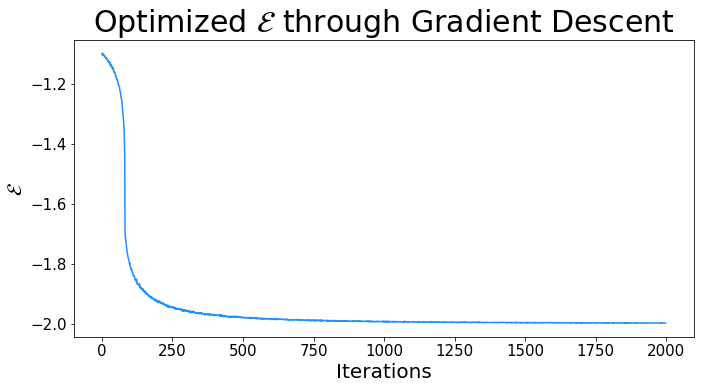

In [358]:
plt.figure(figsize=(10,7))

plt.plot(test_optimization[5][2:], linestyle='-', color='dodgerblue')
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel(r'$\mathcal{E}$', fontsize=20)
plt.title(r'Optimized $\mathcal{E}$ through Gradient Descent', fontsize=30)

plt.tight_layout()

plt.subplots_adjust(top=0.7)

In [359]:
#resultant circuits

op_c = VQE_Circuit(test_optimization[0][-1],test_optimization[1][-1], test_optimization[2][-1],
                   test_optimization[3][-1],test_optimization[4][-1], num_q)

print(op_c[0])
print('*******')
print(op_c[1])
print('*******')
print(op_c[2])

0: ───Ry(1.26400000000001π)───Ry(-0.23599999999999π)───M───
                                                       │
1: ───Ry(1.26400000000001π)───Ry(-0.23599999999999π)───M───
*******
0: ───Ry(0.7560000000000002π)───Ry(0.2560000000000002π)───M───
                                                          │
1: ───Ry(0.7560000000000002π)───Ry(0.2560000000000002π)───M───
*******
0: ───Ry(π)───M───
              │
1: ───Ry(π)───M───
